In [1]:
import sys; sys.path.append("..")
import warnings; warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

In [4]:
import torch
torch.manual_seed(42)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 数据集构建

In [35]:
import numpy as np
import torch

def make_multiclass_classification(n_samples=100, n_features=2, n_classes=3, shuffle=True, noise=0.1):
    """
    生成带噪音的多类别数据(PyTorch 版本）
    输入：
        - n_samples：数据量大小，数据类型为int
        - n_features：特征数量，数据类型为int
        - shuffle：是否打乱数据，数据类型为bool
        - noise：以多大的程度增加噪声，数据类型为None或float，noise为None时表示不增加噪声
    输出：
        - X：特征数据，shape=[n_samples, n_features]
        - y：标签数据, shape=[n_samples]
    """
    # 计算每个类别的样本数量
    n_samples_per_class = [int(n_samples / n_classes) for _ in range(n_classes)]
    for i in range(n_samples - sum(n_samples_per_class)):
        n_samples_per_class[i % n_classes] += 1

    # 初始化特征和标签
    X = torch.zeros((n_samples, n_features), dtype=torch.float32)
    y = torch.zeros((n_samples,), dtype=torch.int32)

    # 随机生成 3 个簇中心
    centroids = torch.randperm(2 ** n_features)[:n_classes]
    centroids_bin = np.unpackbits(centroids.numpy().astype('uint8')).reshape((-1, 8))[:, -n_features:]
    centroids = torch.tensor(centroids_bin, dtype=torch.float32)
    centroids = 1.5 * centroids - 1  # 控制簇中心的分离程度

    # 随机生成特征值
    X[:, :n_features] = torch.randn((n_samples, n_features))

    stop = 0
    # 让每个类的特征值集中在对应簇中心附近
    for k, centroid in enumerate(centroids):
        start, stop = stop, stop + n_samples_per_class[k]
        y[start:stop] = k % n_classes
        X_k = X[start:stop, :n_features]
        # 随机生成线性变换矩阵, 让数据分布更不同
        A = 2 * torch.rand((n_features, n_features)) - 1
        X_k = torch.matmul(X_k, A)
        X_k += centroid # 通过加 让在 原本离得比较开的 几个点开始定义
        X[start:stop, :n_features] = X_k

    # 加噪声
    if noise > 0.0:
        """
        这种“标签扰动”常用于：
            - 分类任务的数据增强
            - 提高模型对噪声数据的鲁棒性
            - 模拟真实世界中标签不准确的情况
            - 比如在一些论文中，这种方法叫：
        Random Label Noise Injection 或 Symmetric Label Noise
        """
        noise_mask = torch.rand((n_samples,)) < noise
        noisy_indices = noise_mask.nonzero(as_tuple=True)[0]
        y[noisy_indices] = torch.randint(0, n_classes, (len(noisy_indices),), dtype=torch.int32)

    # 打乱
    if shuffle:
        idx = torch.randperm(X.shape[0])
        X = X[idx]
        y = y[idx]

    return X, y



X, y = make_multiclass_classification(n_samples=11, n_features=2, n_classes=3, noise=0.2)
print("X:", X)
print("y:", y)

X: tensor([[-1.8455,  0.1256],
        [-1.1675, -0.1458],
        [-1.6129,  0.3397],
        [ 1.0576, -0.5327],
        [-1.1532,  0.4730],
        [ 0.7351, -0.3586],
        [-0.4125,  0.3354],
        [-1.5363, -1.8962],
        [-0.4206, -0.4615],
        [ 0.3264,  0.7767],
        [-0.6780, -0.2906]])
y: tensor([2, 2, 0, 2, 0, 1, 2, 0, 1, 1, 0], dtype=torch.int32)


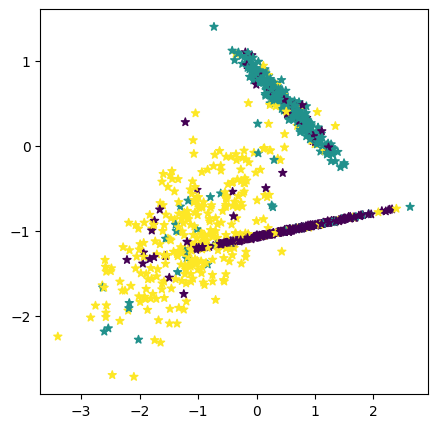

In [36]:
torch.manual_seed(42)
# 采样1000个样本
n_samples = 1000
X, y = make_multiclass_classification(n_samples=n_samples, n_features=2, n_classes=3, noise=0.2)

# 可视化生产的数据集，不同颜色代表不同类别
plt.figure(figsize=(5,5))
plt.scatter(x=X[:, 0].tolist(), y=X[:, 1].tolist(), marker='*', c=y.tolist())
plt.savefig('linear-dataset-vis2.png')
plt.show()

In [19]:
num_train = 640
num_dev = 160
num_test = 200

X_train, y_train = X[:num_train], y[:num_train]
X_dev, y_dev = X[num_train:num_train + num_dev], y[num_train:num_train + num_dev]
X_test, y_test = X[num_train + num_dev:], y[num_train + num_dev:]

# 打印X_train和y_train的维度
print("X_train shape: ", X_train.shape, "y_train shape: ", y_train.shape)



X_train shape:  torch.Size([640, 2]) y_train shape:  torch.Size([640])


In [20]:
print(y_train[:5])

tensor([2, 1, 2, 1, 0], dtype=torch.int32)


### 模型构建